# Exponential smoothing

Esta aula é fortemente baseada no excelente livro de Rob J Hyndman, disponível gratuitamente em [https://otexts.com/fpp2/expsmooth.html](https://otexts.com/fpp2/expsmooth.html), praticamente transcrevendo o que ele fez para um dataset diferente e utilizando a linguagem Python, no lugar do R. Recomendo a leitura dos capítulos 7 até 7.4.

Como série para modelar iremos utilizar o dataset "AirPassengers", ele está disponível no [Kaggle](https://www.kaggle.com/chirag19/air-passengers) e no pacote [datasets](https://www.rdocumentation.org/packages/datasets) do R com a função [AirPassengers](https://www.rdocumentation.org/packages/datasets/versions/3.6.2/topics/AirPassengers).

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

plt.style.use('ggplot')

In [2]:
df = pd.read_csv("AirPassengers.csv")
df["Month"] = pd.to_datetime(df["Month"])
df.set_index("Month", inplace = True)
df = df.asfreq('MS')
df.columns = ["passengers"]
df.head()

,passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


Text(0.5, 0, 'Data')

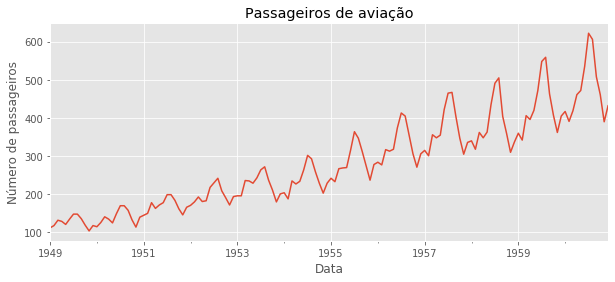

In [3]:
ax = df["passengers"].plot(figsize = (10,4), legend = False, grid = True, title = "Passageiros de aviação")
ax.set_ylabel("Número de passageiros")
ax.set_xlabel("Data")

É possível verificar que a série tem uma tendência de crescimento e claras sazonalidades anuais.

As técnicas mais simples de exponential smoothing não são capazes de lidar com sazonalidades e mais simples nem com tendência. Desta maneira usaremos uma média móvel de 12 meses, para remover as sazonalidades.

In [4]:
df["passengers_MA12"] = df["passengers"].rolling(12).mean()

Text(0.5, 1.0, 'Número de passageiros com média móvel 12')

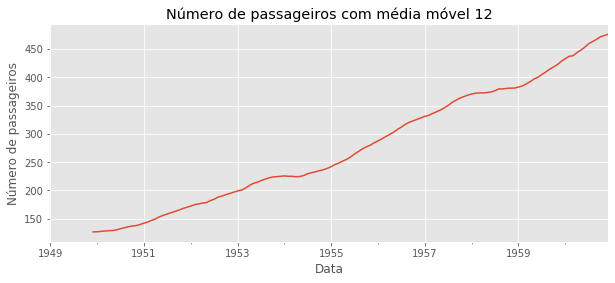

In [5]:
ax = df["passengers_MA12"].plot(figsize = (10,4), legend = False, grid = True, title = "Passageiros de aviação")
ax.set_xlabel("Data")
ax.set_ylabel("Número de passageiros")
ax.set_title("Número de passageiros com média móvel 12")

In [6]:
fit_SimpleExpSmoothing = SimpleExpSmoothing(df.loc['1949-12-01':, ["passengers_MA12"]]).fit(smoothing_level=0.8)

C:\Users\ricar\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


## Exponential Smoothing Simples

Imagine que você precisa prever a temperatura média do dia seguinte ou o valor do dólar, qual seria a melhor maneira de fazer isso rapidamente? Repetir o valor do dia anterior geralmente é uma boa aposta.

A Suavização Exponencial (ou Alisamento) é uma técnica que traz um pouco mais robustez a um modelo deste tipo. Ao invés de apenas utiliza o último ponto, são utilizados todos os pontos possíveis anteriormente.

O grande problema desta técnica é que ela só pode lidar com séries sem tendência e sem sazonalidade. Logo ela irá falhar quando utilizada em nossa série com tendência.

Definimos um $\alpha$ que é quanto do termo anterior arrastamos para a predição:

$$ \hat{y}_{t+1} = \alpha y_t $$

Também adicionamos dois termos atrás:

$$ \hat{y}_{t+1} = \alpha y_t + \alpha(1-\alpha) y_{t-1} $$

Três termos e assim por diante:

$$ \hat{y}_{t+1} = \alpha y_t + \alpha(1-\alpha) y_{t-1} + \alpha(1-\alpha)^2 y_{t-2}+ \cdots $$

Generalizando as equações ficariam:

$$ \hat{y}_{t+1}  = \ell_{t}\\ $$
$$ \ell_{t} = \alpha y_{t} + (1 - \alpha)\ell_{t-1} $$

In [7]:
fit_SimpleExpSmoothing.summary()

Dep. Variable:,endog,No. Observations:,133
Model:,SimpleExpSmoothing,SSE,1847.176
Optimized:,True,AIC,353.932
Trend:,None,BIC,359.712
Seasonal:,None,AICC,354.244
Seasonal Periods:,None,Date:,"Mon, 25 May 2020"
Box-Cox:,False,Time:,11:32:54
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.8000000,alpha,False
initial_level,126.75034,l.0,True


In [8]:
forecast_fit_SimpleExpSmoothing = fit_SimpleExpSmoothing.forecast(12)

Text(0, 0.5, 'Número de passageiros')

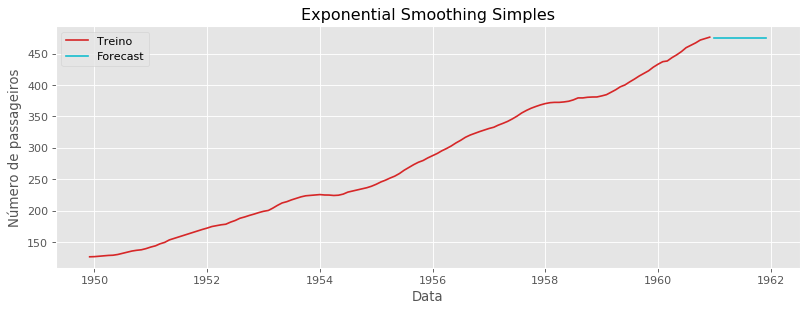

In [9]:
fig, ax = plt.subplots(figsize=(12,4), dpi = 80)
ax.plot(df.loc['1949-12-01':, ["passengers_MA12"]], label = "Treino", c = "tab:red")
ax.plot(forecast_fit_SimpleExpSmoothing, label = "Forecast", c = "tab:cyan")
ax.legend()
ax.set_title("Exponential Smoothing Simples")
ax.set_xlabel("Data")
ax.set_ylabel("Número de passageiros")

Como ela só usa as observações passadas, o modelo não tem espaço para a série continuar crescendo. Isto é, este modelo não é capaz de resultar numa predição maior do que um valor já observado, pois ele apenas pondera os valores observados da série.

A técnica seguinte adiciona a tendência, passando a ser possível modelar a série.

## Método de Holt com tendência

O modelo de Holt's já trata do problema acima, adicionando um termo de tendência.

$ \hat{y}_{t+h} = \ell_{t} + hb_{t} $

Equação de nível:

$ \ell_{t} = \alpha y_{t} + (1 - \alpha)(\ell_{t-1} + b_{t-1}) $

Equação de tendência:
  
$ b_{t} = \beta^*(\ell_{t} - \ell_{t-1}) + (1 -\beta^*)b_{t-1} $

Repare que agora existe uma terceira equação. De certa forma, esta equação funciona como o alisamento para a tendência (a variação entre o ponto atual e o anterior).

- $h$ é qual ponto estamos no forecast (1, 2, 3...);
- $\alpha{}$ o coeficiente de nível;
- $\beta^*$ o coeficiente de tendência.

É possível definir o coeficiente de nível ($\alpha{}$) e o de tendência ($ \beta^*$) manualmente, ou deixar a biblioteca otimizar.

In [10]:
fit_holt = Holt(df.loc["1949-12-01":, "passengers_MA12"]).fit(smoothing_level=0.9, smoothing_slope=0.1, optimized=False)

In [11]:
n_forecast = 60

forecast_holt = fit_holt.forecast(n_forecast)

In [12]:
fit_holt.summary()

Dep. Variable:,endog,No. Observations:,133
Model:,Holt,SSE,254.121
Optimized:,False,AIC,94.112
Trend:,Additive,BIC,105.674
Seasonal:,None,AICC,94.779
Seasonal Periods:,None,Date:,"Mon, 25 May 2020"
Box-Cox:,False,Time:,11:32:55
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9000000,alpha,False
smoothing_slope,0.1000000,beta,False


Com o software otimizando os coeficientes do modelo.

In [13]:
fit_holt_auto = Holt(df.loc["1949-12-01":, "passengers_MA12"]).fit()

C:\Users\ricar\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


In [14]:
fit_holt_auto.summary()

Dep. Variable:,endog,No. Observations:,133
Model:,Holt,SSE,124.863
Optimized:,True,AIC,-0.397
Trend:,Additive,BIC,11.165
Seasonal:,None,AICC,0.270
Seasonal Periods:,None,Date:,"Mon, 25 May 2020"
Box-Cox:,False,Time:,11:32:55
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9905541,alpha,True
smoothing_slope,0.6955128,beta,True


In [15]:
forecast_holt_auto = fit_holt_auto.forecast(n_forecast)

Text(0, 0.5, 'Número de passageiros')

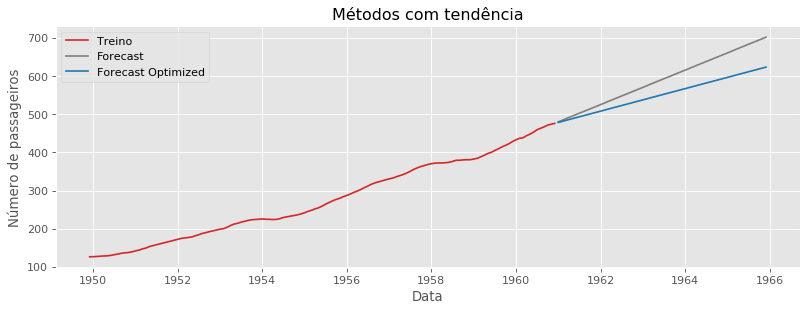

In [16]:
fig, ax = plt.subplots(figsize=(12,4), dpi = 80)
ax.plot(df.loc['1949-12-01':, ["passengers_MA12"]], label = "Treino", c = "tab:red")
ax.plot(forecast_holt, label = "Forecast", c = "tab:grey")
ax.plot(forecast_holt_auto, label = "Forecast Optimized", c = "tab:blue")
ax.legend()
ax.set_title("Métodos com tendência")
ax.set_xlabel("Data")
ax.set_ylabel("Número de passageiros")

Vemos duas curvas no gráfico, a cinza definimos manualmente (sem nenhum método científico) os parâmetros do modelo, no caso da curva azul deixamos o software otimizar os melhores parâmetros.

As duas curvas possuem tendência de crescimento diferentes, mas ambas continuarão crescendo a mesma taxa para sempre. Isso pode não ser esperado em muitas áreas.

## Método de Holt com tendência e damped

É possível modificar o modelo adicionando um termo que limita este crescimento, denotado pela letra ($\phi$). Com este modelo o crescimento converge para uma reta.

$$ \hat{y}_{t+h} = \ell_{t} + (\phi+\phi^2 + \dots + \phi^{h})b_{t}$$

$$ \ell_{t} = \alpha y_{t} + (1 - \alpha)(\ell_{t-1} + \phi b_{t-1})$$

$$ b_{t} = \beta^*(\ell_{t} - \ell_{t-1}) + (1 -\beta^*)\phi b_{t-1}$$

In [17]:
fit_holt_auto_damped = Holt(df.loc["1949-12-01":, "passengers_MA12"], damped=True).fit()

C:\Users\ricar\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


In [18]:
forecast_holt_auto_damped = fit_holt_auto_damped.forecast(n_forecast)

In [19]:
fit_holt_auto_damped.summary()

Dep. Variable:,endog,No. Observations:,133
Model:,Holt,SSE,123.443
Optimized:,True,AIC,0.082
Trend:,Additive,BIC,14.533
Seasonal:,None,AICC,0.978
Seasonal Periods:,None,Date:,"Mon, 25 May 2020"
Box-Cox:,False,Time:,11:32:56
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9598444,alpha,True
smoothing_slope,0.7684837,beta,True


Text(0, 0.5, 'Número de passageiros')

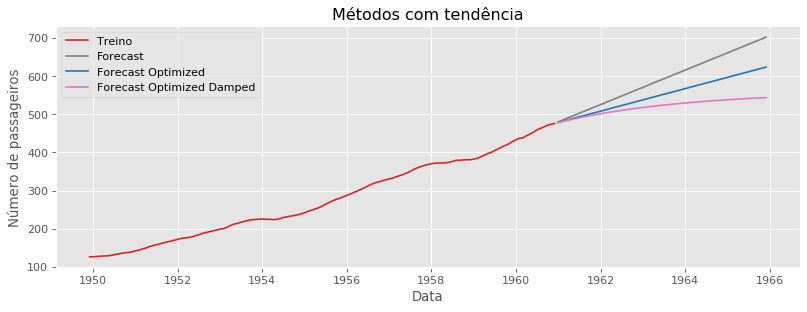

In [20]:
fig, ax = plt.subplots(figsize=(12,4), dpi = 80)
ax.plot(df.loc['1949-12-01':, ["passengers_MA12"]], label = "Treino", c = "tab:red")
ax.plot(forecast_holt, label = "Forecast", c = "tab:grey")
ax.plot(forecast_holt_auto, label = "Forecast Optimized", c = "tab:blue")
ax.plot(forecast_holt_auto_damped, label = "Forecast Optimized Damped", c = "tab:pink")
ax.legend()
ax.set_title("Métodos com tendência")
ax.set_xlabel("Data")
ax.set_ylabel("Número de passageiros")

A curva rosa tem uma tendência a se estabilizar em uma reta, conforme alteramos o parâmetro $\phi$ esta convergência pode ser mais ou menos rápida.

## Holt-Winter's

Agora vamos ao modelo completo, que adiciona o termo com sazonalidade. Desta maneira, passaremos a utilizar a série sem média móvel.

Text(0.5, 0, 'Data')

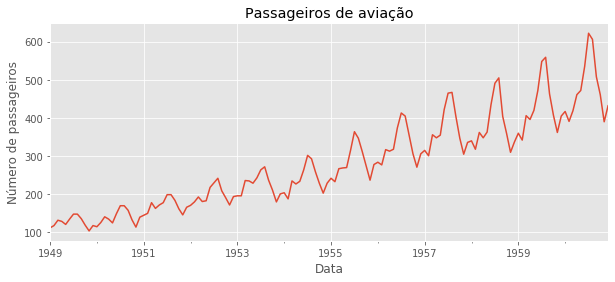

In [21]:
ax = df["passengers"].plot(figsize = (10,4), legend = False, grid = True, title = "Passageiros de aviação")
ax.set_ylabel("Número de passageiros")
ax.set_xlabel("Data")

Existem duas maneiras de adicionar a sazonalidade à série, um método aditivo e um multiplicativo.

O método aditivo é geralmente utilizado quando as variações sazonais são aproximadamente constantes ao longo da série, enquanto o método multiplicativo quando as variações sazonais são proporcionalmente ao nível da série.

Método aditivo:

$$\hat{y}_{t+h} = \ell_{t} + hb_{t} + s_{t+h-m(k+1)}$$

$$\ell_{t} = \alpha(y_{t} - s_{t-m}) + (1 - \alpha)(\ell_{t-1} + b_{t-1})$$

$$b_{t} = \beta^*(\ell_{t} - \ell_{t-1}) + (1 - \beta^*)b_{t-1}$$

$$s_{t} = \gamma (y_{t}-\ell_{t-1}-b_{t-1}) + (1-\gamma)s_{t-m}$$

Método multiplicativo:

$$\hat{y}_{t+h} = (\ell_{t} + hb_{t})s_{t+h-m(k+1)}$$

$$\ell_{t} = \alpha \frac{y_{t}}{s_{t-m}} + (1 - \alpha)(\ell_{t-1} + b_{t-1})$$

$$b_{t} = \beta^*(\ell_{t}-\ell_{t-1}) + (1 - \beta^*)b_{t-1}$$

$$s_{t} = \gamma \frac{y_{t}}{(\ell_{t-1} + b_{t-1})} + (1 - \gamma)s_{t-m}$$

Repare no novo termo $s_t$, que representa a sazonalidade. Onde $\gamma$ é seu parâmetro e $m$ a frequência de sazonalidade, em nosso caso 12 meses do ano. 

In [22]:
fit_holtwinters_add = ExponentialSmoothing(df["passengers"], seasonal_periods=12, trend='add', seasonal='add').fit(use_boxcox=True)

C:\Users\ricar\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\Users\ricar\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


In [23]:
forecast_holtwinters_add = fit_holtwinters_add.forecast(n_forecast)

In [24]:
fit_holtwinters_add.summary()

Dep. Variable:,endog,No. Observations:,144
Model:,ExponentialSmoothing,SSE,16573.360
Optimized:,True,AIC,715.386
Trend:,Additive,BIC,762.903
Seasonal:,Additive,AICC,720.858
Seasonal Periods:,12,Date:,"Mon, 25 May 2020"
Box-Cox:,True,Time:,11:32:57
Box-Cox Coeff.:,0.14802,,
,coeff,code,optimized
smoothing_level,0.3469184,alpha,True
smoothing_slope,3.7876e-09,beta,True


In [25]:
fit_holtwinters_mul = ExponentialSmoothing(df["passengers"], seasonal_periods=12, trend='add', seasonal='mul').fit(use_boxcox=True)

In [26]:
forecast_holtwinters_mul = fit_holtwinters_mul.forecast(n_forecast)

In [27]:
fit_holtwinters_mul.summary()

Dep. Variable:,endog,No. Observations:,144
Model:,ExponentialSmoothing,SSE,15996.280
Optimized:,True,AIC,710.283
Trend:,Additive,BIC,757.800
Seasonal:,Multiplicative,AICC,715.755
Seasonal Periods:,12,Date:,"Mon, 25 May 2020"
Box-Cox:,True,Time:,11:32:58
Box-Cox Coeff.:,0.14802,,
,coeff,code,optimized
smoothing_level,0.3677296,alpha,True
smoothing_slope,7.4859e-12,beta,True


In [28]:
fit_holtwinters_add_damped = ExponentialSmoothing(df["passengers"], seasonal_periods=12, trend='add', seasonal='add', damped=True).fit(use_boxcox=True)

In [29]:
forecast_holtwinters_add_damped = fit_holtwinters_add_damped.forecast(n_forecast)

In [30]:
fit_holtwinters_add_damped.summary()

Dep. Variable:,endog,No. Observations:,144
Model:,ExponentialSmoothing,SSE,16541.059
Optimized:,True,AIC,717.105
Trend:,Additive,BIC,767.592
Seasonal:,Additive,AICC,723.234
Seasonal Periods:,12,Date:,"Mon, 25 May 2020"
Box-Cox:,True,Time:,11:33:03
Box-Cox Coeff.:,0.14802,,
,coeff,code,optimized
smoothing_level,0.3455868,alpha,True
smoothing_slope,4.2061e-16,beta,True


In [31]:
fit_holtwinters_mul_damped = ExponentialSmoothing(df["passengers"], seasonal_periods=12, trend='add', seasonal='mul',  damped=True).fit(use_boxcox=True)

In [32]:
forecast_holtwinters_mul_damped = fit_holtwinters_mul_damped.forecast(n_forecast)

In [33]:
fit_holtwinters_mul_damped.summary()

Dep. Variable:,endog,No. Observations:,144
Model:,ExponentialSmoothing,SSE,15960.438
Optimized:,True,AIC,711.960
Trend:,Additive,BIC,762.447
Seasonal:,Multiplicative,AICC,718.089
Seasonal Periods:,12,Date:,"Mon, 25 May 2020"
Box-Cox:,True,Time:,11:33:09
Box-Cox Coeff.:,0.14802,,
,coeff,code,optimized
smoothing_level,0.3648648,alpha,True
smoothing_slope,3.1185e-15,beta,True


In [34]:
results=pd.DataFrame(index=[r"$\alpha$",r"$\beta$",r"$\phi$",r"$\gamma$",r"$l_0$","$b_0$","SSE"])
params = ['smoothing_level', 'smoothing_slope', 'damping_slope', 'smoothing_seasonal', 'initial_level', 'initial_slope']
results["Additive"]       = [fit_holtwinters_add.params[p] for p in params] + [fit_holtwinters_add.sse]
results["Multiplicative"] = [fit_holtwinters_mul.params[p] for p in params] + [fit_holtwinters_mul.sse]
results["Additive Dam"]   = [fit_holtwinters_add_damped.params[p] for p in params] + [fit_holtwinters_add_damped.sse]
results["Multiplica Dam"] = [fit_holtwinters_mul_damped.params[p] for p in params] + [fit_holtwinters_mul_damped.sse]

results

,Additive,Multiplicative,Additive Dam,Multiplica Dam
$\alpha$,3.469184e-01,3.677296e-01,3.455868e-01,3.648648e-01
$\beta$,3.787613e-09,7.485942e-12,4.206130e-16,3.118546e-15
$\phi$,NaN,NaN,9.987702e-01,9.993005e-01
$\gamma$,5.548956e-01,4.269648e-01,5.555635e-01,4.299888e-01
$l_0$,8.212021e+00,8.290826e+00,8.208516e+00,8.290444e+00
$b_0$,2.209492e-02,2.644166e-02,2.413730e-02,2.782358e-02
SSE,1.657336e+04,1.599628e+04,1.654106e+04,1.596044e+04


Text(0, 0.5, 'Número de passageiros')

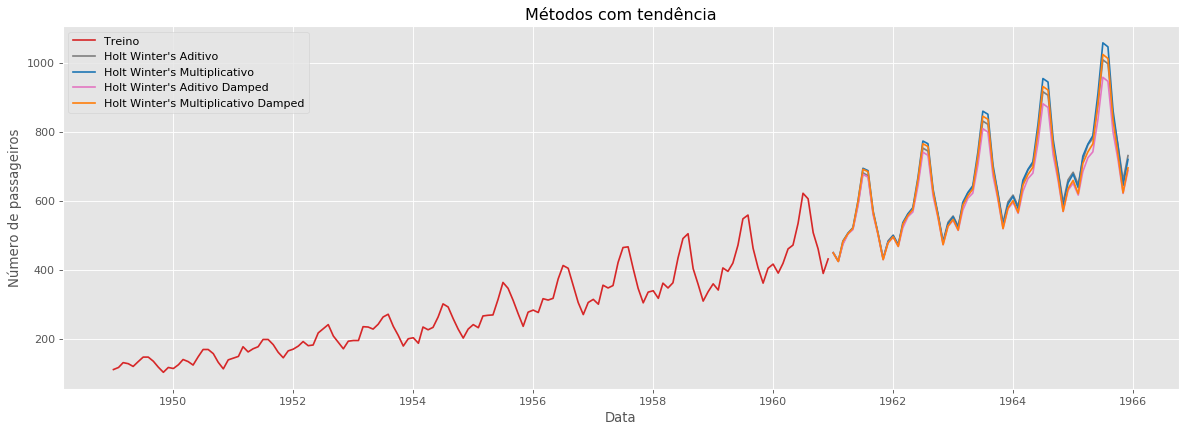

In [35]:
fig, ax = plt.subplots(figsize=(18,6), dpi = 80)
ax.plot(df["passengers"], label = "Treino", c = "tab:red")
ax.plot(forecast_holtwinters_add, label = "Holt Winter's Aditivo", c = "tab:grey")
ax.plot(forecast_holtwinters_mul, label = "Holt Winter's Multiplicativo", c = "tab:blue")
ax.plot(forecast_holtwinters_add_damped, label = "Holt Winter's Aditivo Damped", c = "tab:pink")
ax.plot(forecast_holtwinters_mul_damped, label = "Holt Winter's Multiplicativo Damped", c = "tab:orange")

ax.legend()
ax.set_title("Métodos com tendência")
ax.set_xlabel("Data")
ax.set_ylabel("Número de passageiros")

Este método possui fundamento estatístico, podendo gerar intervalos de confiança. Infelizmente o pacote Statsmodels ainda não possui um bom [suporte para isso](https://github.com/statsmodels/statsmodels/issues/6359).

O livro do Hyndman tem capítulos sobre o intervalo de confiança das predições, além disso seu pacote do R [Forecast](https://cran.r-project.org/web/packages/forecast/index.html) possui suporte para tal. Uma opção seria utilizar o pacote [rpy2](https://pypi.org/project/rpy2/) para rodar o código do R no Python, que a depender da implementação pode ser uma solução, ou mesmo utilizar o R diretamente.

## Bibliografia:

[1] Hyndman, Rob J., and George Athanasopoulos. Forecasting: principles and practice. OTexts, 2014. Disponível gratuitamente em [https://otexts.com/fpp2/](https://otexts.com/fpp2/)

[2] [Ajuda do statsmodels](https://www.statsmodels.org/stable/examples/notebooks/generated/exponential_smoothing.html)